<a href="https://colab.research.google.com/github/yuhui-0611/contest/blob/main/Poverty_Prediction_Challenge_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회귀

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
X = pd.read_csv('/content/drive/MyDrive/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/contest/train_hh_gt.csv')
y2 = pd.read_csv('/content/drive/MyDrive/contest/train_rates_gt.csv')

In [29]:
X_tr = pd.read_csv("/content/drive/MyDrive/contest/X_tr.csv")
X_val = pd.read_csv("/content/drive/MyDrive/contest/X_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/contest/X_test.csv")
y_tr = pd.read_csv("/content/drive/MyDrive/contest/y_tr.csv")
y_val = pd.read_csv("/content/drive/MyDrive/contest/y_val.csv")
test_id = pd.read_csv("/content/drive/MyDrive/contest/test_id.csv")
train = pd.read_csv("/content/drive/MyDrive/contest/train (3).csv")

In [30]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss.split(train, groups=train["survey_id"]))

train_df = train.iloc[tr_idx]
val_df   = train.iloc[val_idx]

**< 모델 입력에 필요한 최종 변수 >**

- X_tr
- X_val
- X_test
- y_tr
- y_val
- test_id

성능 = 가구-레벨 소비 예측과 빈곤율 예측 오류 기반

< 주요 평가 지표 >
- 가중 평균 오차(metric)

> 빈곤율 예측 오차 → 약 90% 비중

> 가구 소비 예측 오차 → 약 10% 비중

즉, 빈곤율 예측 정확도가 사실상 승부를 가른다고 보면 됨

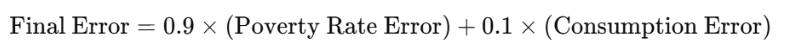

**< 범주형 분리 >**

In [31]:
cat_cols_tr = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
cat_cols_val = [c for c in X_val.columns if X_val[c].dtype == "object"]
cat_cols_test = [c for c in X_test.columns if X_test[c].dtype == "object"]

# **< Consumption Error >**

# CatBoost

In [32]:
!pip install catboost

In [33]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [34]:
# 범주형 컬럼 인덱스
cat_features = [X_tr.columns.get_loc(c) for c in cat_cols_tr]

cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100
)

cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)

0:	learn: 9.8616661	test: 9.6851264	best: 9.6851264 (0)	total: 934ms	remaining: 31m 6s
100:	learn: 6.1140711	test: 6.1297780	best: 6.1297780 (100)	total: 27.3s	remaining: 8m 34s
200:	learn: 5.8617548	test: 5.9549315	best: 5.9549315 (200)	total: 38.4s	remaining: 5m 43s
300:	learn: 5.7042877	test: 5.8861553	best: 5.8861553 (300)	total: 50.3s	remaining: 4m 43s
400:	learn: 5.5820593	test: 5.8470058	best: 5.8469845 (399)	total: 1m 3s	remaining: 4m 13s
500:	learn: 5.4943589	test: 5.8265272	best: 5.8265272 (500)	total: 1m 16s	remaining: 3m 49s
600:	learn: 5.4167376	test: 5.8087992	best: 5.8087992 (600)	total: 1m 33s	remaining: 3m 38s
700:	learn: 5.3569745	test: 5.7969965	best: 5.7969965 (700)	total: 1m 45s	remaining: 3m 14s
800:	learn: 5.3009368	test: 5.7885098	best: 5.7885098 (800)	total: 1m 56s	remaining: 2m 54s
900:	learn: 5.2472148	test: 5.7812339	best: 5.7812095 (897)	total: 2m 5s	remaining: 2m 33s
1000:	learn: 5.2033248	test: 5.7742670	best: 5.7742345 (997)	total: 2m 17s	remaining: 2m 1

In [35]:
val_pred = cb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
rmse

np.float64(5.753445714540127)

# LightGBM

In [36]:
# !pip install lightgbm

In [37]:
import lightgbm as lgb

In [38]:
X_tr_lgb   = X_tr.copy()
X_val_lgb  = X_val.copy()
X_test_lgb = X_test.copy()

for c in cat_cols_tr:
    X_tr_lgb[c]   = X_tr_lgb[c].astype("category")
    X_val_lgb[c]  = X_val_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")

In [39]:
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(
    X_tr_lgb, y_tr,
    eval_set=[(X_val_lgb, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 72046, number of used features: 85
[LightGBM] [Info] Start training from score 11.674833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1340]	valid_0's rmse: 5.77862	valid_0's l2: 33.3925


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=3000,
              objective='regression', random_state=42, subsample=0.8)

In [40]:
val_pred_lgb = lgb_model.predict(X_val_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
rmse_lgb

np.float64(5.778620727163594)

# XGBoost

In [41]:
X_tr_xgb   = X_tr.copy()
X_val_xgb  = X_val.copy()
X_test_xgb = X_test.copy()

# **< Poverty Rate Error >**

# LightGBM

In [67]:
val_sid = val_df["survey_id"].astype(str).to_numpy()   # survey_id
val_true = np.asarray(y_val).reshape(-1)   # 실제 소비값
val_pred_lgb = val_pred_lgb.astype(np.float32)   # 예측 소비값
val_true = val_true.astype(np.float32)   # 실제 소비값

threshold 값(3.17, 3.94, …) 이 컬럼 이름 안에 존재

In [68]:
# y2에서 poverty rate 정답 컬럼만 선택
rate_cols = [c for c in y2.columns if c.startswith("pct_hh_below_")]

# 컬럼 이름에서 threshold 값만 추출 -> 오름차순 정렬
threshold = {c: float(c.split("pct_hh_below_")[1]) for c in rate_cols}
rate_cols_sorted = sorted(rate_cols, key=lambda c: threshold[c])

thresholds = np.array([threshold[c] for c in rate_cols_sorted], dtype=np.float32)

In [69]:
rate_cols

['pct_hh_below_3.17',
 'pct_hh_below_3.94',
 'pct_hh_below_4.60',
 'pct_hh_below_5.26',
 'pct_hh_below_5.88',
 'pct_hh_below_6.47',
 'pct_hh_below_7.06',
 'pct_hh_below_7.70',
 'pct_hh_below_8.40',
 'pct_hh_below_9.13',
 'pct_hh_below_9.87',
 'pct_hh_below_10.70',
 'pct_hh_below_11.62',
 'pct_hh_below_12.69',
 'pct_hh_below_14.03',
 'pct_hh_below_15.64',
 'pct_hh_below_17.76',
 'pct_hh_below_20.99',
 'pct_hh_below_27.37']

In [70]:
y2_map = {}

# y2를 survey 단위로 한 줄씩 읽음
for _, row in y2[["survey_id"] + rate_cols_sorted].iterrows():
    sid = str(int(row["survey_id"])) if str(row["survey_id"]).endswith(".0") else str(row["survey_id"])   # 해당 survey의 ID
    y2_map[sid] = row[rate_cols_sorted].to_numpy(dtype=np.float32)

In [71]:
val_pred_lgb = np.asarray(val_pred_lgb).astype(np.float32)
val_true_lgb = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_lgb = 0.0
poverty_cnt_lgb = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_lgb = val_pred_lgb[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_lgb = (pred_cons_lgb[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_lgb = np.abs(pr_pred_lgb - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_lgb += float(ape_lgb.sum())
    poverty_cnt_lgb += ape_lgb.size

poverty_error_lgb = poverty_err_sum_lgb / poverty_cnt_lgb
print("Poverty Error (LGB):", poverty_error_lgb)

Poverty Error (LGB): 0.09869032784512169


In [72]:
cons_error_lgb = float(np.mean(np.abs(val_pred_lgb - val_true_lgb) / np.clip(val_true_lgb, 1e-6, None)))
print("Consumption Error (LGB):", cons_error_lgb)

Consumption Error (LGB): 0.3131718933582306


### Final Error

In [73]:
final_error_lgb = 0.9 * poverty_error_lgb + 0.1 * cons_error_lgb
print("Final Error (LGB):", final_error_lgb)

Final Error (LGB): 0.12013848439643258


## **log**

In [74]:
y_tr_log  = np.log1p(y_tr)
y_val_log = np.log1p(y_val)

In [75]:
lgb_model_log = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model_log.fit(
    X_tr_lgb, y_tr_log,
    eval_set=[(X_val_lgb, y_val_log)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)

val_pred_lgb_log = lgb_model_log.predict(X_val_lgb)
val_pred_lgb2 = np.expm1(val_pred_lgb_log)
val_pred_lgb2 = np.maximum(val_pred_lgb2, 0)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 72046, number of used features: 85
[LightGBM] [Info] Start training from score 2.328690
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1960]	valid_0's rmse: 0.307713	valid_0's l2: 0.0946873


In [80]:
rmse_lgb_log = np.sqrt(mean_squared_error(y_val, val_pred_lgb2))
rmse_lgb_log

np.float64(5.825499405961469)

In [81]:
val_pred_lgb2 = np.asarray(val_pred_lgb2).astype(np.float32)
val_true_lgb2 = np.asarray(y_val).reshape(-1).astype(np.float32)

poverty_err_sum_lgb2 = 0.0
poverty_cnt_lgb2 = 0

for sid in np.unique(val_sid):
    gt_rates = y2_map.get(sid, None)
    if gt_rates is None:
        continue

    mask = (val_sid == sid)   # boolean
    pred_cons_lgb2 = val_pred_lgb2[mask]   # 예측 소비값

    # threshold별 예측 poverty rate = mean(cons_pred < threshold)
    # (n,1) < (k,) 하면 (n,k) bool 만들어짐
    # mean axis=0 하면 길이 k 벡터가 됨
    pr_pred_lgb2 = (pred_cons_lgb2[:, None] < thresholds[None, :]).mean(axis=0).astype(np.float32)
    ape_lgb2 = np.abs(pr_pred_lgb2 - gt_rates) / np.clip(gt_rates, 1e-6, None)

    poverty_err_sum_lgb2 += float(ape_lgb2.sum())
    poverty_cnt_lgb2 += ape_lgb2.size

poverty_error_lgb2 = poverty_err_sum_lgb2 / poverty_cnt_lgb2
print("Poverty Error (LGB):", poverty_error_lgb2)

Poverty Error (LGB): 0.053628080769589075


In [82]:
cons_error_lgb2 = float(np.mean(np.abs(val_pred_lgb2 - val_true_lgb2) / np.clip(val_true_lgb2, 1e-6, None)))
print("Consumption Error (LGB):", cons_error_lgb2)

Consumption Error (LGB): 0.28331997990608215


### Final Error

In [83]:
final_error_lgb2 = 0.9 * poverty_error_lgb2 + 0.1 * cons_error_lgb2
print("Final Error (LGB):", final_error_lgb2)

Final Error (LGB): 0.07659727068323838


# Submisson

In [88]:
# log 스케일 예측
test_pred_log = lgb_model_log.predict(X_test_lgb)

# 원래 스케일로 복원
test_pred_1 = np.expm1(test_pred_log)

# 음수 방지 (필수)
test_pred_1 = np.maximum(test_pred_1, 0)

In [84]:
test_id.head()

,survey_id,hhid
0,400000,400001
1,400000,400002
2,400000,400003
3,400000,400004
4,400000,400005


In [109]:
test_sid = test_id["survey_id"].to_numpy()
test_hhid = test_id["hhid"].to_numpy()

In [110]:
submission_cons = pd.DataFrame({
    "survey_id": test_sid,
    "hhid": test_hhid,
    "cons_ppp17": test_pred_1
})

In [111]:
submission_cons.to_csv("predicted_household_consumption.csv", index=False)

# 첫 줄 확인
with open("predicted_household_consumption.csv", "r") as f:
    for _ in range(3):
        print(f.readline().strip())

survey_id,hhid,cons_ppp17
400000,400001,10.831185081637955
400000,400002,7.074364950909254


In [112]:
# survey_id별 poverty rate 계산
pov_rows = []
for sid in np.unique(test_sid):
    mask = (test_sid == sid)
    cons = test_pred_1[mask]

    # 각 threshold에 대해 비율 계산: mean(cons < threshold)
    # cons: (n,), thresholds: (k,) -> (k,)
    rates = (cons[:, None] < thresholds[None, :]).mean(axis=0)

    row = {"survey_id": sid}
    for c, r in zip(rate_cols_sorted, rates):
        row[c] = float(r)
    pov_rows.append(row)

submission_pov = pd.DataFrame(pov_rows, columns=["survey_id"] + rate_cols_sorted)
submission_pov.to_csv("predicted_poverty_distribution.csv", index=False)

# 첫 줄 확인
with open("predicted_poverty_distribution.csv", "r") as f:
    for _ in range(2):
        print(f.readline().strip())

survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
400000,0.019962389700564156,0.0600028930999566,0.1147114132793288,0.17416461738753075,0.2325473745117894,0.28534644871980325,0.33476059597859104,0.38782004918269924,0.44290467235642994,0.4938232315926515,0.5410675538839866,0.5897294951540576,0.6381889194271662,0.6880659626790105,0.7415015188774772,0.7945320410820194,0.8464921163026182,0.8988282945175756,0.952871401706929


## **threshold weight**

## **survey별 bias 보정**

- validation에서 survey별로 예측의 중앙값(또는 평균) 을 맞춰주는 방식

# CatBoost